In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [18]:
data = pd.read_excel('/Users/tanuj/Desktop/ENB2012_data.xlsx')

# Features and Target (Heating Load)
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
y = data['Y1']


In [19]:

print("Dataset Info:")
print(data.info())

print("\nSummary Statistics:")
print(data.describe())

print("\nMissing Values:")
print(data.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB
None

Summary Statistics:
               X1          X2          X3          X4         X5          X6  \
count  768.000000  768.000000  768.000000  768.000000  768.00000  768.000000   
mean     0.764167  671.708333  318.500000  176.604167    5.25000    3.500000   
std      0.105777   88.086116   43.626481   45.165950    1.75114    1.118763   
min      0.620000  514.500000  245.00000

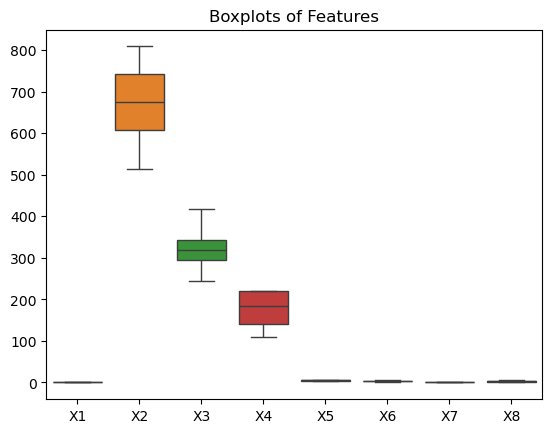

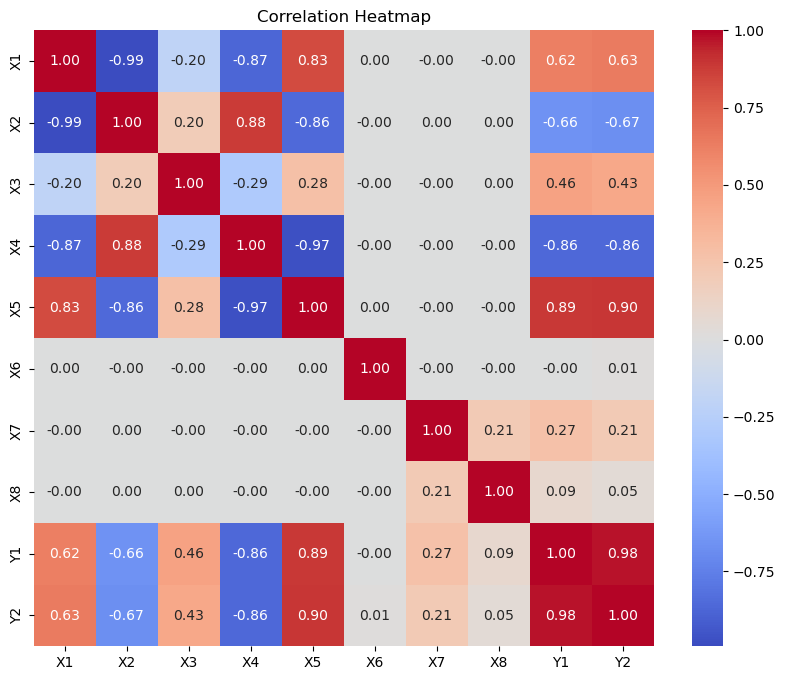

In [30]:

sns.boxplot(data=X)
plt.title("Boxplots of Features")
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [21]:

cat_cols = ['X6', 'X8']  
num_cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X7']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:

preprocessor_linear = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

pipe_linear = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('regressor', LinearRegression())
])

pipe_linear.fit(X_train, y_train)
y_pred_linear = pipe_linear.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("\nLinear Regression Results:")
print(f"MSE: {mse_linear:.2f}, RMSE: {rmse_linear:.2f}, R2: {r2_linear:.2f}")



Linear Regression Results:
MSE: 8.25, RMSE: 2.87, R2: 0.92


In [23]:

num_transformer_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor_poly = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), cat_cols),
    ('num', num_transformer_poly, num_cols)
])

pipe_poly = Pipeline([
    ('preprocessor', preprocessor_poly),
    ('regressor', LinearRegression())
])


scores_poly = cross_val_score(pipe_poly, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"\nPolynomial Regression Cross-Validation MSE (degree=2): {-np.mean(scores_poly):.2f}")

pipe_poly.fit(X_train, y_train)
y_pred_poly = pipe_poly.predict(X_test)

mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print("\nPolynomial Regression Results (degree=2):")
print(f"MSE: {mse_poly:.2f}, RMSE: {rmse_poly:.2f}, R2: {r2_poly:.2f}")



Polynomial Regression Cross-Validation MSE (degree=2): 0.30

Polynomial Regression Results (degree=2):
MSE: 0.33, RMSE: 0.57, R2: 1.00


In [24]:

pipe_ridge = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('regressor', Ridge())
])

param_grid_ridge = {'regressor__alpha': [0.1, 1, 10]}
grid_ridge = GridSearchCV(pipe_ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train, y_train)

best_alpha = grid_ridge.best_params_['regressor__alpha']
y_pred_ridge = grid_ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\nRidge Regression Results:")
print(f"Best Alpha: {best_alpha}")
print(f"MSE: {mse_ridge:.2f}, RMSE: {rmse_ridge:.2f}, R2: {r2_ridge:.2f}")



Ridge Regression Results:
Best Alpha: 0.1
MSE: 8.27, RMSE: 2.88, R2: 0.92


In [25]:

pipe_tree = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

param_grid_tree = {
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_samples_leaf': [5, 10, 20]  # Pruning to reduce overfitting
}

grid_tree = GridSearchCV(pipe_tree, param_grid_tree, cv=5, scoring='neg_mean_squared_error')
grid_tree.fit(X_train, y_train)

best_params_tree = grid_tree.best_params_
y_pred_tree = grid_tree.predict(X_test)

mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("\nDecision Tree Regressor Results (Bonus):")
print(f"Best Params: {best_params_tree}")
print(f"MSE: {mse_tree:.2f}, RMSE: {rmse_tree:.2f}, R2: {r2_tree:.2f}")



Decision Tree Regressor Results (Bonus):
Best Params: {'regressor__max_depth': 7, 'regressor__min_samples_leaf': 5}
MSE: 0.36, RMSE: 0.60, R2: 1.00


In [34]:
# Get the feature importances from the best estimator (Decision Tree)
importances = grid_tree.best_estimator_.named_steps['regressor'].feature_importances_

# Get all feature names (categorical one-hot + numerical)
ohe_feature_names = grid_tree.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(cat_cols)
feature_names = list(ohe_feature_names) + num_cols

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances from Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (801134921.py, line 2)

In [26]:

print("\nModel Comparison:")
print(f"Linear Regression: MSE={mse_linear:.2f}, RMSE={rmse_linear:.2f}, R2={r2_linear:.2f}")
print(f"Polynomial Regression (degree=2): MSE={mse_poly:.2f}, RMSE={rmse_poly:.2f}, R2={r2_poly:.2f}")
print(f"Ridge Regression (alpha={best_alpha}): MSE={mse_ridge:.2f}, RMSE={rmse_ridge:.2f}, R2={r2_ridge:.2f}")
print(f"Decision Tree (params={best_params_tree}): MSE={mse_tree:.2f}, RMSE={rmse_tree:.2f}, R2={r2_tree:.2f}")



Model Comparison:
Linear Regression: MSE=8.25, RMSE=2.87, R2=0.92
Polynomial Regression (degree=2): MSE=0.33, RMSE=0.57, R2=1.00
Ridge Regression (alpha=0.1): MSE=8.27, RMSE=2.88, R2=0.92
Decision Tree (params={'regressor__max_depth': 7, 'regressor__min_samples_leaf': 5}): MSE=0.36, RMSE=0.60, R2=1.00


In [27]:

print("\nModel Comparison:")
print(f"Linear Regression: MSE={mse_linear:.2f}, RMSE={rmse_linear:.2f}, R2={r2_linear:.2f}")
print(f"Polynomial Regression (degree=2): MSE={mse_poly:.2f}, RMSE={rmse_poly:.2f}, R2={r2_poly:.2f}")
print(f"Ridge Regression (alpha={best_alpha}): MSE={mse_ridge:.2f}, RMSE={rmse_ridge:.2f}, R2={r2_ridge:.2f}")
print(f"Decision Tree (params={best_params_tree}): MSE={mse_tree:.2f}, RMSE={rmse_tree:.2f}, R2={r2_tree:.2f}")



Model Comparison:
Linear Regression: MSE=8.25, RMSE=2.87, R2=0.92
Polynomial Regression (degree=2): MSE=0.33, RMSE=0.57, R2=1.00
Ridge Regression (alpha=0.1): MSE=8.27, RMSE=2.88, R2=0.92
Decision Tree (params={'regressor__max_depth': 7, 'regressor__min_samples_leaf': 5}): MSE=0.36, RMSE=0.60, R2=1.00


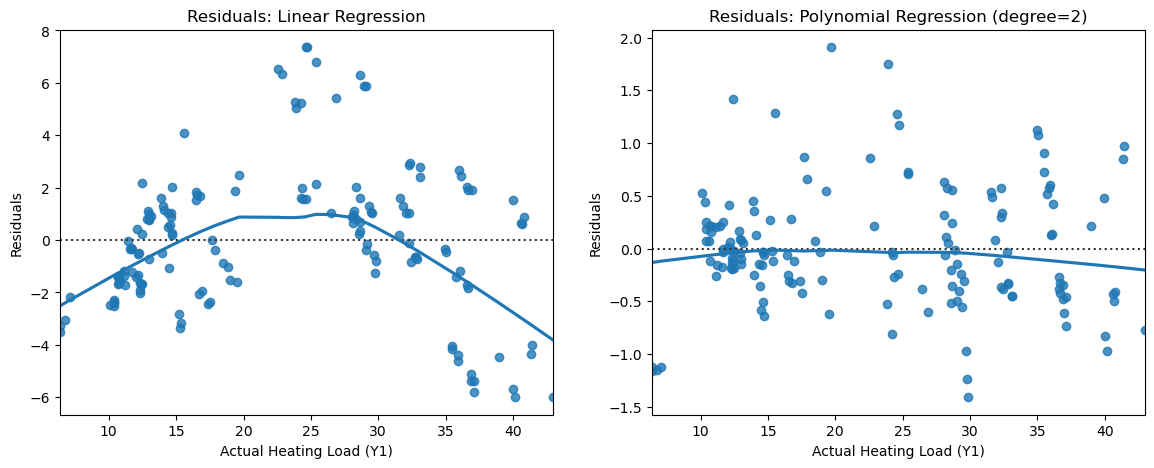

In [28]:

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.residplot(x=y_test, y=y_pred_linear, lowess=True)
plt.title('Residuals: Linear Regression')
plt.xlabel('Actual Heating Load (Y1)')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.residplot(x=y_test, y=y_pred_poly, lowess=True)
plt.title('Residuals: Polynomial Regression (degree=2)')
plt.xlabel('Actual Heating Load (Y1)')
plt.ylabel('Residuals')

plt.show()


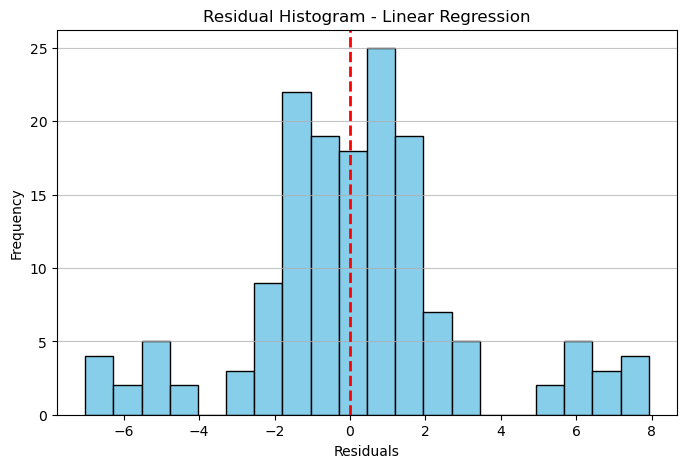

In [33]:
plt.figure(figsize=(8, 5))
plt.hist(residuals_linear, bins=20, edgecolor='black', color='skyblue')
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)  # Adds a vertical line at 0 residual
plt.title('Residual Histogram - Linear Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


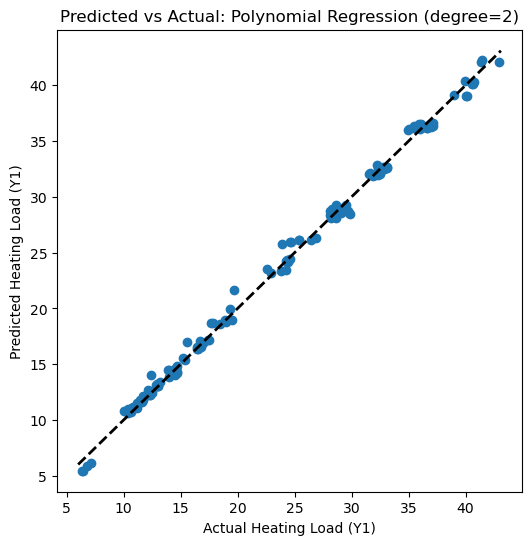

In [29]:

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_poly)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Heating Load (Y1)')
plt.ylabel('Predicted Heating Load (Y1)')
plt.title('Predicted vs Actual: Polynomial Regression (degree=2)')
plt.show()
